# Practical Work 3 - Second experiment : men vs women

Authors : Lionel Burgbacher & David Jaquet

In [2]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

%matplotlib inline

In [3]:
PATH = './vowels/'

## Utils

In [4]:
# Read all the wav files
def read_files(files):
    readed = []
    
    for file in files:
        readed.append(wav.read(os.path.join(PATH, file)))
    
    return readed

# Generate the Mel-Frequency Cepstrum Coefficients
def generate_mfcc(files):
    mfcc_array = []
    for (rate, X) in files:
        mfcc_array.append(mfcc(X, samplerate=rate, nfft=1024))
        
    return mfcc_array

# Calculate the mean of the features for the given array
def calculate_feature_mean(mfcc):
    feature_mean = []
    
    for feature in mfcc:
        mean = np.mean(feature,axis=0)
        feature_mean.append(mean)
    return feature_mean

# Calculate the median of the features for the given array
def calculate_feature_std(mfcc):
    feature_std = []
    
    for feature in mfcc:
        deviation = np.std(feature,axis=0)
        feature_std.append(deviation)
    return feature_std

# Calculate the standard deviation of the features for the given array
def calculate_feature_median(mfcc):
    feature_median = []
    
    for feature in mfcc:
        median = np.median(feature,axis=0)
        feature_median.append(median)
    return feature_median

# Normalize data per columns between min and max
def scale(array, min, max):
    nom = (array-array.min(axis=0))*(max-min)
    denom = array.max(axis=0) - array.min(axis=0)
    denom[denom==0] = 1
    return min + nom/denom

## Experiment

In [5]:
# src : https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
# Collect all the men files
men_files = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and (file.startswith('nam') or file.startswith('sam')) and file.endswith('.wav'))]

# Collect all the women files
women_files = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and (file.startswith('naf') or file.startswith('saf')) and file.endswith('.wav'))]

In [6]:
men = read_files(men_files)
women = read_files(women_files)
    
men_mfcc = generate_mfcc(men)
women_mfcc = generate_mfcc(women)

men_feature = calculate_feature_median(men_mfcc)
women_feature = calculate_feature_median(women_mfcc)

In [7]:
# Append all the datas
datas = []
MAN = [-1]
WOMAN = [1]

for feature in men_feature:
    datas.append(np.append(feature, MAN))

for feature in women_feature:
    datas.append(np.append(feature, WOMAN))
    
datas = scale(np.asarray(datas), -1, 1)

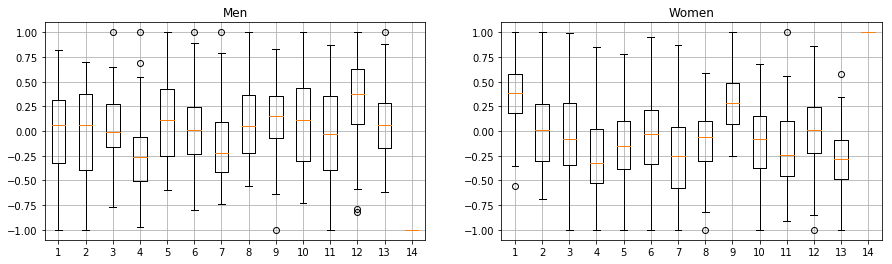

In [8]:
pl.figure(figsize=(15,4))
pl.subplot(1,2,1)
pl.boxplot(datas[:72])
pl.title('Men')
pl.grid()
pl.subplot(1,2,2)
pl.boxplot(datas[72:])
pl.title('Women')
pl.grid()

In [9]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

input_data = datas[:,0:13]
output_data = datas[:,13]

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    
    # 13 features in input and 1 output to determine man or woman
    nn = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((input_data, output_data),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...


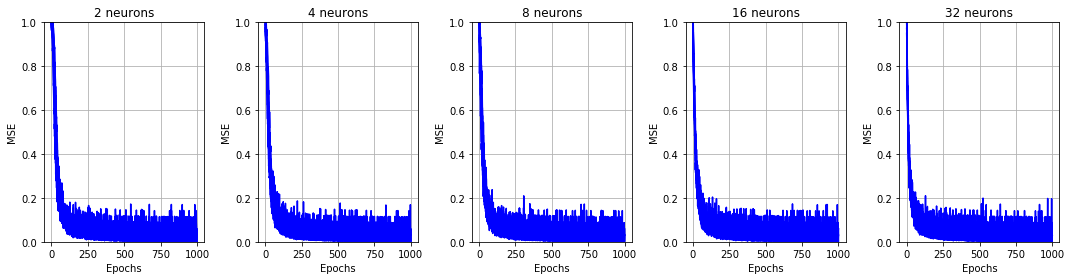

In [10]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

Dans les graphiques ci-dessus, on peut voir que le `MSE` se stabilise, quel que soit le nombre de neurones à partir de **400 epochs**. Nous avons donc de choisir cette valeur d'epochs pour la suite de l'expérience.

In [11]:
K = 5
N_TESTS = 10
EPOCHS = 400
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [12]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13, h, 1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            datas,      # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


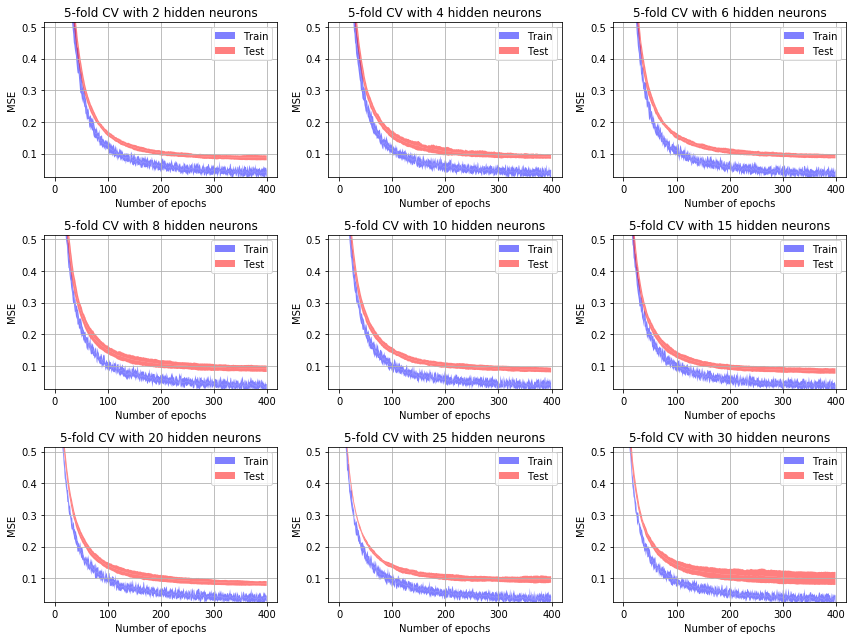

In [13]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

25 neurones à l'air bien

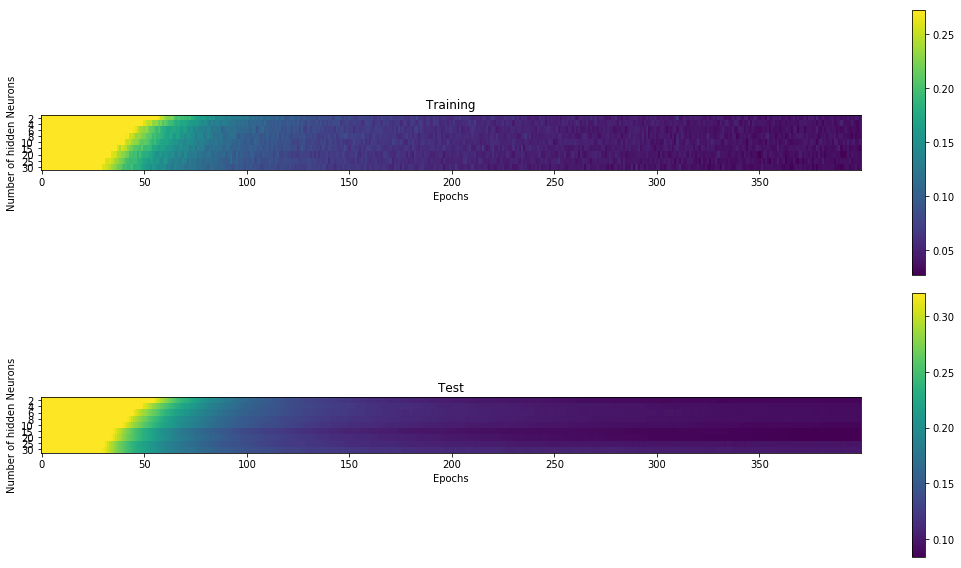

In [14]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

On garde 25 neurones

In [15]:
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.5
EPOCHS = 400
N_NEURONS = 25

In [24]:
nn = mlp.MLP([13, N_NEURONS, 1], 'tanh')

# Initialize to -1 to be sure they are updated
best_MSE_train = -1
best_MSE_test = -1
best_f_score = -1

# Initialize to 2 to be sure they are updated
worst_MSE_train = 2
worst_MSE_test = 2
worst_f_score = 2

best_conf_mat = np.zeros((2, 2))
worst_conf_mat = np.zeros((2, 2))

tps = 0 # conf_mat[0][0]
fns = 0 # conf_mat[0][1]
fps = 0 # conf_mat[1][0]
tns = 0 # conf_mat[1][1]

for i in range(0, 100):
    print("Iteration", i)
    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               datas,
                                                               k=K,
                                                               learning_rate=LEARNING_RATE,
                                                               momentum=MOMENTUM,
                                                               epochs=EPOCHS,
                                                               threshold=0.0)
    if best_MSE_train < MSE_train:
        best_MSE_train = MSE_train
    elif worst_MSE_train > MSE_train:
        worst_MSE_train = MSE_train
        
    if best_MSE_test < MSE_test:
        best_MSE_test = MSE_test
    elif worst_MSE_test > MSE_test:
        worst_MSE_test = MSE_test
        
    tps += conf_mat[0][0]
    fns += conf_mat[0][1]
    fps += conf_mat[1][0]
    tns += conf_mat[1][1]
        
    if best_conf_mat[0][0] + best_conf_mat[1][1] < conf_mat[0][0] + conf_mat[1][1]:
        best_conf_mat = conf_mat
    elif worst_conf_mat[0][1] + worst_conf_mat[1][0] < conf_mat[0][1] + conf_mat[1][0]:
        worst_conf_mat = conf_mat

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [30]:
print('Worst MSE training: ', worst_MSE_train)
print('Best MSE training: ', best_MSE_train)
print('Worst MSE test: ', worst_MSE_test)
print('Best MSE test: ', best_MSE_test)
print('Best confusion matrix:')
print(best_conf_mat)
print('Worst confusion matrix:')
print(worst_conf_mat)


mean_results = [tps/100, fns/100, fps/100, tns/100]
print(mean_results)

# precision = tp/(tp + fp)
mean_precision = mean_results[0] / (mean_results[0] + mean_results[2])
print("Mean precision =", mean_precision)

# recall = tp/(tp + fn)
mean_recall = mean_results[0] / (mean_results[0] + mean_results[1])
print("Mean recall =", mean_recall)

# F1 Score = 2 x precision x recall / ( precision + recall)
mean_f1 = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
print("Mean F1 Score =", mean_f1)

Worst MSE training:  0.026717243814210128
Best MSE training:  0.03931731099773361
Worst MSE test:  0.061610606138911686
Best MSE test:  0.1324164477549239
Best confusion matrix:
[[72.  0.]
 [ 2. 70.]]
Worst confusion matrix:
[[68.  4.]
 [ 3. 69.]]
[70.91, 1.09, 2.61, 69.39]
Mean precision = 0.9644994559303591
Mean recall = 0.9848611111111111
Mean F1 Score = 0.9745739417262232
